### 3.2.2 AlexNet
AlexNet是我们真正意义上的一个深度卷积神经网络，其发表在2012年的论文 [ImageNet Classification with Deep Convolutional Neural Networks](chrome-extension://ikhdkkncnoglghljlkmcimlnlhkeamad/pdf-viewer/web/viewer.html?file=https%3A%2F%2Fproceedings.neurips.cc%2Fpaper%2F2012%2Ffile%2Fc399862d3b9d6b76c8436e924a68c45b-Paper.pdf) 是深度学习的奠基作之一，其也赢下了当年ImageNet数据集的冠军（1百万个样本，1000种类别）。截止到我写这篇博客(2022年)为知，其引用数已经达到了102838次。论文当中，有些技术细节现在来看或许是多余的，但是其很多工作，对后面的一系列研究起到重要的启发式作用。

## 学习表征
在合理地复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。
在计算机视觉当中，最底层可能检测边缘，纹理等信息。正如AlexNet论文当中描述的，在底层的网络当中，模型学到了一些类似于传统滤波器的特征抽取器，论文中的图像生动表示了这种底层特征信息，其为AlexNet第一层学习到的特征抽取器:
![](https://zh-v2.d2l.ai/_images/filters.png)


AlexNet的更高层建立在这些底层表示的基础上，以表示更大的特征，如眼睛、鼻子、草叶等等。而更高的层可以检测整个物体，如人、飞机、狗或飞盘。（高层具有更多的**语义信息**）最终的隐藏神经元可以学习图像的综合表示，从而使属于不同类别的数据易于区分。尽管一直有一群执着的研究者不断钻研，试图学习视觉数据的逐级表征，然而很长一段时间里这些尝试都未有突破。深度卷积神经网络的突破出现在2012年。突破可归因于两个关键因素: 数据与硬件计算。

AlexNet论文当中采用的硬件是两块3GB的GTX 580实现卷积运算。但实际上，在今天的硬件水平下，AlexNet做模型并行是有些多余的。但面对当今更大的模型(eg BERT, Transformer)，模型并行又重新流行了起来。

### 网络架构
2012年，AlexNet横空出世。它首次证明了学习到的特征可以超越手工设计的特征。它一举打破了计算机视觉研究的现状。 AlexNet使用了**8层**卷积神经网络，并以很大的优势赢得了2012年ImageNet图像识别挑战赛。下图为其论文中的网络示意图:
![](https://s2.loli.net/2022/02/06/qWFM1EjodptX7ay.png)

为了让读者更容易看懂，我们简化其分开GPU进行训练的设计，其架构如下图所示（左图为LeNet，右图为AlexNet）:
![](https://zh-v2.d2l.ai/_images/alexnet.svg)

**注意**:后续的代码实现亦不会考虑分开GPU来进行训练。

可以看到，AlexNet和LeNet的设计理念非常相似，但也存在显著差异:
* AlexNet比相对较小的LeNet5要深得多。
* AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。
* AlexNet使用ReLU而不是sigmoid作为其激活函数。
* AlexNet十大池化层（LeNet使用平均池化层），并且卷积层有更大的和窗口和步长（因为图片有更大的像素）。
![](https://s2.loli.net/2022/02/07/ehTzgiSsrUdY2Nu.png)
主要的改进为:
* dropout 丢弃法，而不是权重衰减，避免过拟合。（当然，论文中还用到了两种数据增强的方法避免过拟合，随机crop与通道变换）
    * 后面的论文基本解释dropout等价于$l2$正则，但无法用表达式写出来。
* ReLU 取代 sigmoid，更简单更快
* 使用最大池化层 MaxPooling

AlexNet的出现极大的推动了计算机视觉，和有监督学习的发展。

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

下面通过Pytorch API构造AlexNet。这里为了捕捉对象，我们开始使用一个核大小为11的窗口,我们使用MNIST数据集，因此输入通道数为1。

In [4]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

测试一下每层的输出:

In [1]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

NameError: name 'torch' is not defined

#### 训练网络
以Fashion-MNIST图像为数据集，其分辨率为$28 \times 28$像素，远低于ImageNet的$224 \times 224$ 为了令其训练成功，我们将其增加到$224 \times 224$（**但实际应用当中，并不建议这样做！**）
为了演示方便，我们借助d2l库的函数完成数据集导入和训练。

* 读取数据集

In [6]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 训练网络

下面函数支持在GPU和CPU上训练

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """计算模型精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估状态
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量, 预测总数
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调中所使用的，这里不用理会
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [8]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """模型训练函数"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.327, train acc 0.880, test acc 0.880
384.6 examples/sec on cuda:0


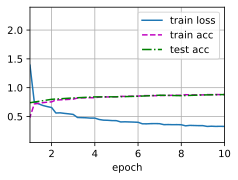

In [20]:
lr, num_epochs = 0.01, 10
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())